In [2]:
# Tutorial by www.pylessons.com
# Tutorial written for - Tensorflow 1.15, Keras 2.2.4

import os
import random
import gym
import pylab
import numpy as np
from collections import deque 
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, Add
from keras.optimizers import Adam, RMSprop
from keras import backend as K

In [3]:
def OurModel(input_shape, action_space, dueling):
    X_input = Input(input_shape)
    X = X_input

    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    X = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X)

    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)
    
    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)

    if dueling:
        state_value = Dense(1, kernel_initializer='he_uniform')(X)
        state_value = Lambda(lambda s: K.expand_dims(s[:, 0], -1), output_shape=(action_space,))(state_value)

        action_advantage = Dense(action_space, kernel_initializer='he_uniform')(X)
        action_advantage = Lambda(lambda a: a[:, :] - K.mean(a[:, :], keepdims=True), output_shape=(action_space,))(action_advantage)

        X = Add()([state_value, action_advantage])
    else:
        # Output Layer with # of actions: 2 nodes (left, right)
        X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name='CartPole Dueling DDQN model')
    model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model

In [6]:
class DQNAgent:
    def __init__(self, env_name):
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.env.seed(0)  
        # by default, CartPole-v1 has max episode steps = 500
        self.env._max_episode_steps = 4000
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.EPISODES = 1000
        self.memory = deque(maxlen=2000)
        
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01 # minimum exploration probability
        self.epsilon_decay = 0.999 # exponential decay rate for exploration prob
        self.batch_size = 32 
        self.train_start = 1000

        # defining model parameters
        self.ddqn = True # use doudle deep q network
        self.Soft_Update = False # use soft parameter update
        self.dueling = True # use dealing netowrk

        self.TAU = 0.1 # target network soft update hyperparameter

        self.Save_Path = 'Models'
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.scores, self.episodes, self.average = [], [], []
        
        if self.ddqn:
            print("----------Double DQN--------")
            self.Model_name = os.path.join(self.Save_Path,"Dueling DDQN_"+self.env_name+".h5")
        else:
            print("-------------DQN------------")
            self.Model_name = os.path.join(self.Save_Path,"Dueling DQN_"+self.env_name+".h5")
        
        # create main model and target model
        self.model = OurModel(input_shape=(self.state_size,), action_space = self.action_size, dueling = self.dueling)
        self.target_model = OurModel(input_shape=(self.state_size,), action_space = self.action_size, dueling = self.dueling)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        if not self.Soft_Update and self.ddqn:
            self.target_model.set_weights(self.model.get_weights())
            return
        if self.Soft_Update and self.ddqn:
            q_model_theta = self.model.get_weights()
            target_model_theta = self.target_model.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_model.set_weights(target_model_theta)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, self.batch_size)

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        # predict Q-values for starting state using the main network
        target = self.model.predict(state)
        # predict best action in ending state using the main network
        target_next = self.model.predict(next_state)
        # predict Q-values for ending state using the target network
        target_val = self.target_model.predict(next_state)

        for i in range(len(minibatch)):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                if self.ddqn: # Double - DQN
                    # current Q Network selects the action
                    # a'_max = argmax_a' Q(s', a')
                    a = np.argmax(target_next[i])
                    # target Q Network evaluates the action
                    # Q_max = Q_target(s', a'_max)
                    target[i][action[i]] = reward[i] + self.gamma * (target_val[i][a])   
                else: # Standard - DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
                    target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)

    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Steps', fontsize=18)
        dqn = 'DQN_'
        softupdate = ''
        dueling = ''
        if self.ddqn: dqn = 'DDQN_'
        if self.Soft_Update: softupdate = '_soft'
        if self.dueling: dueling = '_Dueling'
        try:
            pylab.savefig(dqn+self.env_name+softupdate+dueling+".png")
        except OSError:
            pass

        return str(self.average[-1])[:5]
    
    def run(self):
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                #self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.env._max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:
                    # every step update target model
                    self.update_target_model()
                    
                    # every episode, plot the result
                    average = self.PlotModel(i, e)
                     
                    print("episode: {}/{}, score: {}, e: {:.2}, average: {}".format(e, self.EPISODES, i, self.epsilon, average))
                    if i == self.env._max_episode_steps:
                        print("Saving trained model as", self.Model_name)
                        #self.save(self.Model_name)
                        break
                self.replay()

    def test(self):
        self.load('ddqn.h5')
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, i))
                    break



<Figure size 1296x648 with 0 Axes>

----------Double DQN--------
Model: "CartPole Dueling DDQN model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2560        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           16448       dense_2[0][0]                    
___________________________________________

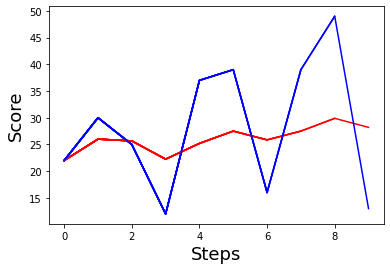

In [7]:
if __name__ == "__main__":
    env_name = 'CartPole-v1'
    agent = DQNAgent(env_name)
    agent.run()
    #agent.test()

In [7]:
agent.model.save('ddqn.h5')

In [8]:
agent.load('ddqn.h5')
for e in range(100):
    state = agent.env.reset()
    state = np.reshape(state, [1, agent.state_size])
    done = False
    i = 0
    while not done:
        #agent.env.render()
        action = np.argmax(agent.model.predict(state))
        next_state, reward, done, _ = agent.env.step(action)
        state = np.reshape(next_state, [1, agent.state_size])
        i += 1
        if done:
            print("episode: {}/{}, score: {}".format(e, agent.EPISODES, i))
            break

episode: 0/10, score: 154
episode: 1/10, score: 143
episode: 2/10, score: 154
episode: 3/10, score: 145
episode: 4/10, score: 142
episode: 5/10, score: 144
episode: 6/10, score: 140
episode: 7/10, score: 148
episode: 8/10, score: 144
episode: 9/10, score: 140
episode: 10/10, score: 155
episode: 11/10, score: 146
episode: 12/10, score: 152
episode: 13/10, score: 151
episode: 14/10, score: 151
episode: 15/10, score: 146
episode: 16/10, score: 148
episode: 17/10, score: 155
episode: 18/10, score: 151
episode: 19/10, score: 149
episode: 20/10, score: 147
episode: 21/10, score: 147
episode: 22/10, score: 158
episode: 23/10, score: 149
episode: 24/10, score: 151
episode: 25/10, score: 150
episode: 26/10, score: 152
episode: 27/10, score: 146
episode: 28/10, score: 155
episode: 29/10, score: 148
episode: 30/10, score: 150
episode: 31/10, score: 147
episode: 32/10, score: 150
episode: 33/10, score: 141
episode: 34/10, score: 149
episode: 35/10, score: 150
episode: 36/10, score: 152
episode: 37